# **Text mining: SENTIMENT ANALYSIS**

## 🎓 Master’s Program in Data Science & Advanced Analytics  
**Nova IMS** | Spring Semester 24/25  
**Course:** Text Mining


## 👥 Team **Group 34**  
- **[Diogo Duarte]** | [20240525]  
- **[Philippe Dutranoit]** | [20240518]  
- **[Rodrigo Sardinha]** | [20211627]
- **[Rui Luz]** | [20211628]   
## 📊 Goal of the notebook


The specific goal of this notebook is to **test and compare multiple classifiers** using **CLS embeddings extracted from pretrained transformer models**, namely:
- `cardiffnlp/twitter-roberta-base-sentiment-latest`
- `cardiffnlp/twitter-xlm-roberta-base-sentiment`
- `finiteautomata/bertweet-base-sentiment-analysis`

We evaluate the following machine learning models using these embeddings:
- Logistic Regression  
- Support Vector Machine (SVC)  
- Random Forest  
- Gradient Boosting  
- XGBoost  
- Multi-Layer Perceptron (MLPClassifier)

Performance is assessed on a validation set using **accuracy** and **macro-averaged F1 score**.


# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

from transformers import AutoTokenizer, RobertaForSequenceClassification, pipeline

import torch
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

# Load Data

In [2]:
X_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('Y_train.csv')
X_test = pd.read_csv('X_val.csv')
y_test = pd.read_csv('Y_val.csv')

# X_train = pd.read_csv('../Data/X_train.csv')
# y_train = pd.read_csv('../Data/y_train.csv')
# X_test = pd.read_csv('../Data/X_val.csv')
# y_test = pd.read_csv('../Data/y_val.csv')

# Pre-trained Pipeline

Here we are using the Huggingface pipeline("sentiment-analysis") to evaluate the performance of a pre-trained Transformer model on our validation set. The model is used in inference mode only, without being trained on our data.

In [3]:
# Define pipeline evaluation function
def evaluate_pipeline_model(model_name, val_texts, y_true):
    print(f"\n--- Evaluating model: {model_name} ---")

    # Common pipeline arguments
    pipeline_args = {
        "task": "sentiment-analysis",
        "model": model_name,
        "tokenizer": model_name,
        "batch_size": 16,
        "truncation": True
    }

    # Add device_map if not distilbert
    if "distilbert" not in model_name:
        pipeline_args["device_map"] = "auto"

    # Create pipeline
    classifier = pipeline(**pipeline_args)

    # Run pipeline
    preds = classifier(val_texts)

    # Choose correct label map depending on model
    # first, check what labels look like
    example_label = preds[0]['label']

    if example_label in ["negative", "positive", "neutral"]:
        label_map = {"negative": 0, "positive": 1,"neutral": 2}

    elif example_label in ["LABEL_0", "LABEL_1", "LABEL_2"]:
        label_map = {"LABEL_0": 0, "LABEL_1": 1, "LABEL_2": 2}

    elif example_label in ["NEG", "POS", "NEU"]:
        label_map = {"NEG": 0, "POS": 1,"NEU": 2}

    else:
        raise ValueError(f"Unknown label format: {example_label}")

    # Convert predictions
    y_pred_pipeline = [label_map[pred['label']] for pred in preds]

    # Compute metrics
    acc = accuracy_score(y_true, y_pred_pipeline)
    f1 = f1_score(y_true, y_pred_pipeline, average='macro')

    # Print classification report
    print(classification_report(y_true, y_pred_pipeline, digits=4))

     # Plot confusion matrix
    cm = confusion_matrix(y_true, y_pred_pipeline)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1,2], yticklabels=[0,1,2])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {model_name.split('/')[-1]}") # just the model name
    plt.show()

    # Return metrics
    return acc, f1

#### Baseline Evaluation


--- Evaluating model: cardiffnlp/twitter-roberta-base-sentiment-latest ---


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT e

              precision    recall  f1-score   support

           0     0.4907    0.4583    0.4740       288
           1     0.6084    0.4519    0.5186       385
           2     0.7371    0.8074    0.7707      1236

    accuracy                         0.6831      1909
   macro avg     0.6121    0.5726    0.5878      1909
weighted avg     0.6740    0.6831    0.6751      1909



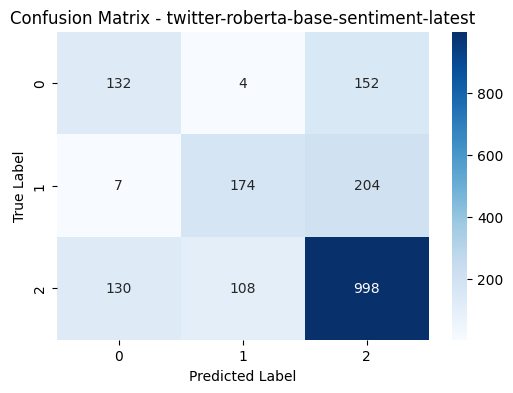


--- Evaluating model: cardiffnlp/twitter-xlm-roberta-base-sentiment ---


Device set to use cuda:0
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


              precision    recall  f1-score   support

           0     0.3432    0.4444    0.3873       288
           1     0.3816    0.2052    0.2669       385
           2     0.6712    0.7217    0.6955      1236

    accuracy                         0.5757      1909
   macro avg     0.4653    0.4571    0.4499      1909
weighted avg     0.5633    0.5757    0.5626      1909



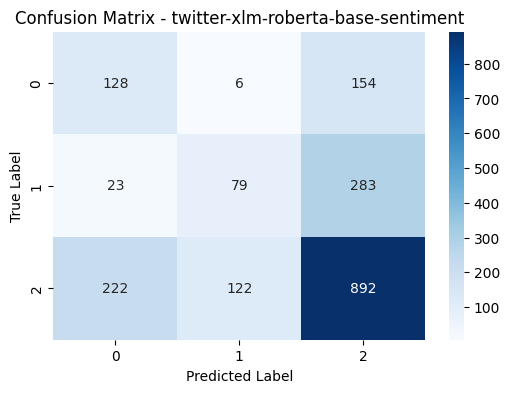


--- Evaluating model: finiteautomata/bertweet-base-sentiment-analysis ---


emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
Device set to use cuda:0


              precision    recall  f1-score   support

           0     0.5046    0.5729    0.5366       288
           1     0.5032    0.4104    0.4521       385
           2     0.7311    0.7500    0.7404      1236

    accuracy                         0.6548      1909
   macro avg     0.5796    0.5778    0.5764      1909
weighted avg     0.6509    0.6548    0.6515      1909



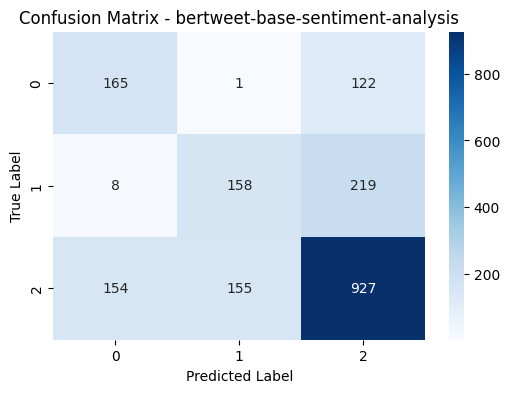

In [4]:
# Prepare texts and true labels once
val_texts = X_test["text"].tolist()
y_true = y_test["label"].tolist()

# List of models to test
model_list = [
    'cardiffnlp/twitter-roberta-base-sentiment-latest',
    'cardiffnlp/twitter-xlm-roberta-base-sentiment',
    'finiteautomata/bertweet-base-sentiment-analysis'
]

results_pipeline = []

# Run loop
for model_name in model_list:

    acc, f1 = evaluate_pipeline_model(model_name, val_texts, y_true)
    results_pipeline.append({
        'Model': model_name.split("/")[-1],
        'Accuracy': acc,
        'F1-Score': f1
    })

In [5]:
# Convert results to DataFrame and sort by Macro F1
pipeline_results_df = pd.DataFrame(results_pipeline)
pipeline_results_df = pipeline_results_df.sort_values(by='F1-Score', ascending=False).reset_index(drop=True)

print("\n--- Classifier Comparison Table ---")
display(pipeline_results_df)


--- Classifier Comparison Table ---


,Model,Accuracy,F1-Score
0,twitter-roberta-base-sentiment-latest,0.683080,0.587751
1,bertweet-base-sentiment-analysis,0.654793,0.576358
2,twitter-xlm-roberta-base-sentiment,0.575694,0.449900


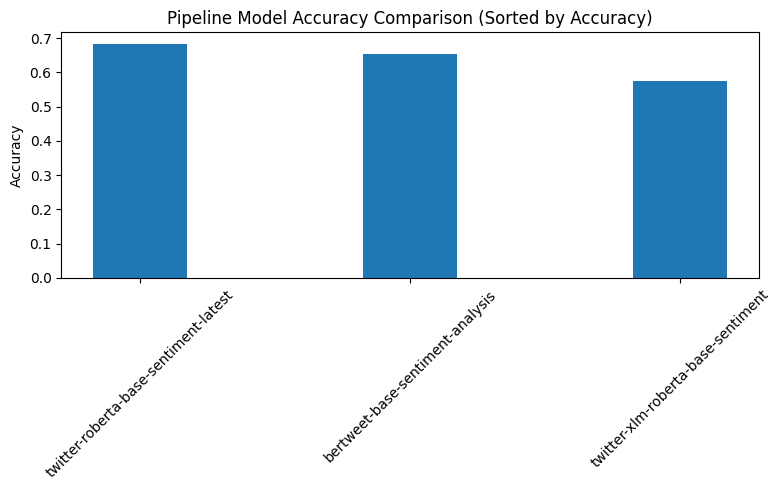

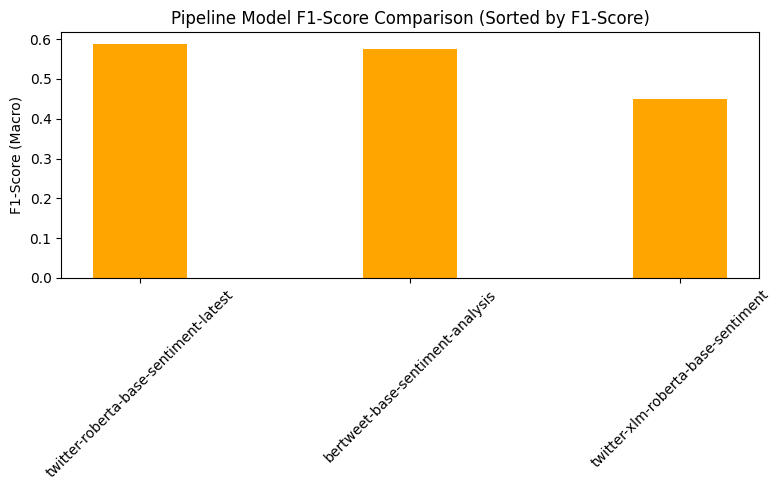

In [6]:
# ---- Plot sorted by Accuracy ----
sorted_by_acc = pipeline_results_df.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)

x = np.arange(len(sorted_by_acc))
width = 0.35

plt.figure(figsize=(8, 5))
plt.bar(x, sorted_by_acc['Accuracy'], width)
plt.xticks(x, sorted_by_acc['Model'], rotation=45)
plt.ylabel("Accuracy")
plt.title("Pipeline Model Accuracy Comparison (Sorted by Accuracy)")
plt.tight_layout()
plt.show()

# ---- Plot sorted by F1-Score ----
sorted_by_f1 = pipeline_results_df.sort_values(by='F1-Score', ascending=False).reset_index(drop=True)

x = np.arange(len(sorted_by_f1))

plt.figure(figsize=(8, 5))
plt.bar(x, sorted_by_f1['F1-Score'], width, color='orange')
plt.xticks(x, sorted_by_f1['Model'], rotation=45)
plt.ylabel("F1-Score (Macro)")
plt.title("Pipeline Model F1-Score Comparison (Sorted by F1-Score)")
plt.tight_layout()
plt.show()


# Pre-trained LM for Embeddings + Training multiple Classifiers

In this section, we use pre-trained language models as feature extractors to obtain the representations of tweets. Specifically, we extract CLS token embeddings from each tweet and use them as input features to traditional machine learning classifiers.

This approach allows us to benefit from the rich semantic knowledge captured by large-scale Transformer models, while maintaining the flexibility to experiment with various classifiers.

### Extract CLS Embeddings

In [7]:
def extract_cls_embeddings(texts, feature_extractor):
    """
    Extract CLS token embeddings from a list of texts using a feature extraction model.

    Handles both multi-layer and single-layer outputs.

    Args:
        texts (list of str): Input texts.
        feature_extractor (transformers.pipeline): Feature extraction pipeline.

    Returns:
        np.ndarray: Array of CLS embeddings.
    """

    print("Extracting embeddings...")
    # Run the feature extractor pipeline on the input text
    embeddings = feature_extractor(texts, batch_size=16)

    # Detect if emb[0] is a list of layers
    # Take the first example to check its structure
    first_emb = embeddings[0][0]

    # If embeddings[0][0] is a list -> multiple layers -> take last layer's CLS token
    if isinstance(first_emb, list):
        print("Detected multi-layer embeddings → using last layer.")
        cls_embeddings = np.array([np.array(emb[0][-1]) for emb in embeddings])
    else:
        # If embeddings[0][0] is already a vector -> single layer -> take directly
        print("Detected single-layer embeddings.")
        cls_embeddings = np.array([np.array(emb[0]) for emb in embeddings])

    print(f"Extracted CLS embeddings shape: {cls_embeddings.shape}")
    return cls_embeddings

### Train and Evaluate Classifier

In [8]:
def train_and_evaluate_classifier(classifier, X_train, y_train, X_val, y_val):
    """
    Train the classifiers and evaluate their performance on the validation set.

    Args:
        classifier: A scikit-learn compatible classifier (with fit and predict methods).
        X_train (np.ndarray): Training feature vectors.
        y_train (list or np.ndarray): Training labels.
        X_val (np.ndarray): Validation feature vectors.
        y_val (list or np.ndarray): Validation labels.

    Returns:
        tuple: (macro F1-score, accuracy)
    """

    print(f"\n--- Training {classifier.__class__.__name__} ---")

    # Train the classifier
    classifier.fit(X_train, y_train)
    # Predict on the validation set
    y_pred = classifier.predict(X_val)
    # Predict on the training set
    y_train_pred = classifier.predict(X_train)

    # classification report
    report = classification_report(y_val, y_pred, digits=4, output_dict=True)
    # Get train report
    train_report = classification_report(y_train, y_train_pred, digits=4, output_dict=True)
    # print classification report
    print(classification_report(y_val, y_pred, digits=4))

    # confusion matrix
    cm = confusion_matrix(y_val, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1,2], yticklabels=[0,1,2])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {classifier.__class__.__name__}")
    plt.show()

    # Extract train metrics
    train_macro_f1 = train_report['macro avg']['f1-score']
    train_accuracy = accuracy_score(y_train, y_train_pred)
    # Extract val metrics
    macro_f1 = report['macro avg']['f1-score']
    accuracy = accuracy_score(y_val, y_pred)

    return macro_f1, accuracy, train_macro_f1, train_accuracy

### Run feature-extraction + test different classifiers

In [9]:
# Load feature-extraction pipeline
feature_extractor = pipeline(
    "feature-extraction",
    model='cardiffnlp/twitter-roberta-base-sentiment-latest',
    tokenizer='cardiffnlp/twitter-roberta-base-sentiment-latest',
    batch_size=16,
    device_map="auto",
    truncation=True
)

# Prepare training and validation texts/labels
X_train_texts = X_train["text"].tolist()
y_train_labels = y_train["label"].tolist()

X_val_texts = X_test["text"].tolist()
y_val_labels = y_test["label"].tolist()

# Extract CLS embeddings
X_train_features = extract_cls_embeddings(X_train_texts, feature_extractor)
X_val_features = extract_cls_embeddings(X_val_texts, feature_extractor)


Device set to use cuda:0
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Extracting embeddings...
Detected multi-layer embeddings → using last layer.
Extracted CLS embeddings shape: (7634, 768)
Extracting embeddings...
Detected multi-layer embeddings → using last layer.
Extracted CLS embeddings shape: (1909, 768)


### Define classifiers and run loop


--- Training LogisticRegression ---
              precision    recall  f1-score   support

           0     0.6861    0.6528    0.6690       288
           1     0.7577    0.7065    0.7312       385
           2     0.8613    0.8892    0.8750      1236

    accuracy                         0.8167      1909
   macro avg     0.7684    0.7495    0.7584      1909
weighted avg     0.8140    0.8167    0.8149      1909



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


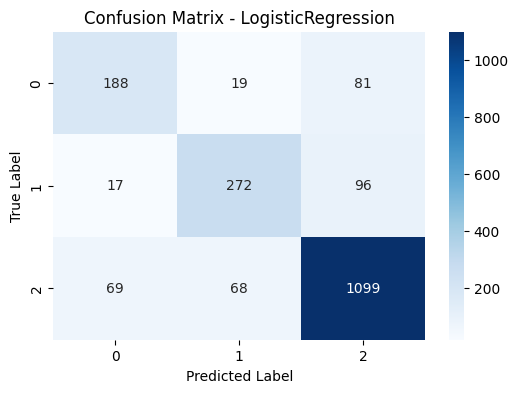


--- Training SVC ---
              precision    recall  f1-score   support

           0     0.7523    0.5694    0.6482       288
           1     0.8328    0.6597    0.7362       385
           2     0.8326    0.9337    0.8802      1236

    accuracy                         0.8235      1909
   macro avg     0.8059    0.7209    0.7549      1909
weighted avg     0.8205    0.8235    0.8162      1909



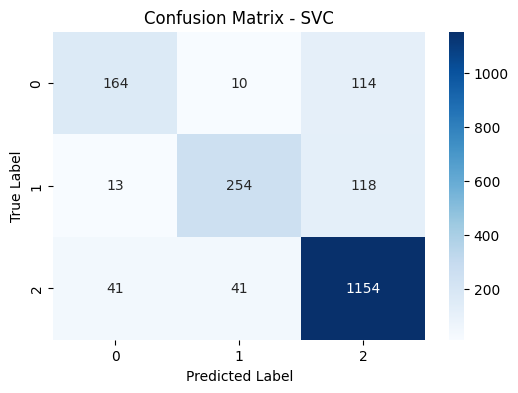


--- Training RandomForestClassifier ---
              precision    recall  f1-score   support

           0     0.7796    0.5035    0.6118       288
           1     0.8735    0.5558    0.6794       385
           2     0.7997    0.9563    0.8710      1236

    accuracy                         0.8072      1909
   macro avg     0.8176    0.6719    0.7207      1909
weighted avg     0.8116    0.8072    0.7933      1909



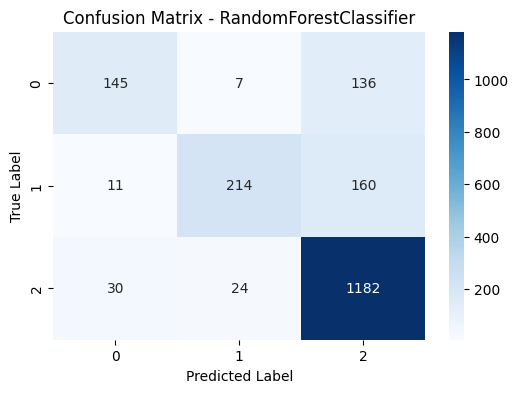


--- Training GradientBoostingClassifier ---
              precision    recall  f1-score   support

           0     0.7523    0.5694    0.6482       288
           1     0.8268    0.6571    0.7323       385
           2     0.8332    0.9337    0.8806      1236

    accuracy                         0.8229      1909
   macro avg     0.8041    0.7201    0.7537      1909
weighted avg     0.8197    0.8229    0.8156      1909



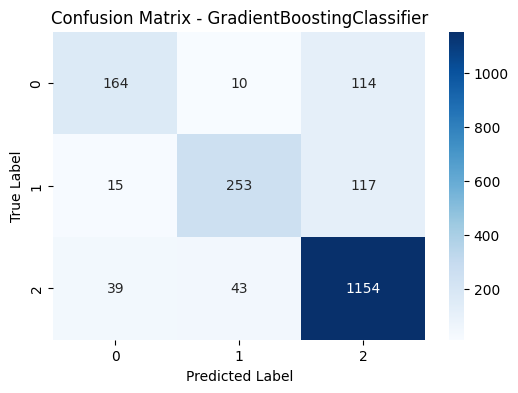


--- Training XGBClassifier ---


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:59:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0     0.7629    0.6146    0.6808       288
           1     0.8387    0.6753    0.7482       385
           2     0.8464    0.9361    0.8890      1236

    accuracy                         0.8350      1909
   macro avg     0.8160    0.7420    0.7726      1909
weighted avg     0.8322    0.8350    0.8292      1909



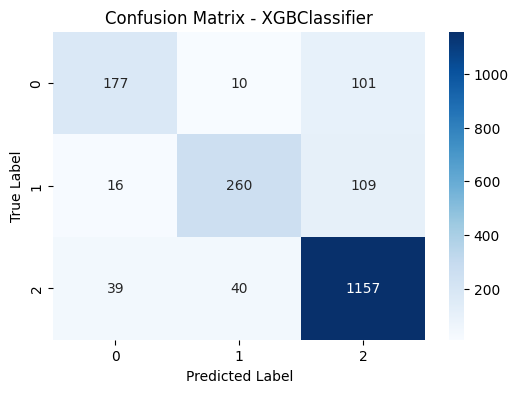


--- Training MLPClassifier ---
              precision    recall  f1-score   support

           0     0.7252    0.6597    0.6909       288
           1     0.7769    0.7688    0.7728       385
           2     0.8791    0.9005    0.8897      1236

    accuracy                         0.8376      1909
   macro avg     0.7937    0.7763    0.7845      1909
weighted avg     0.8353    0.8376    0.8361      1909



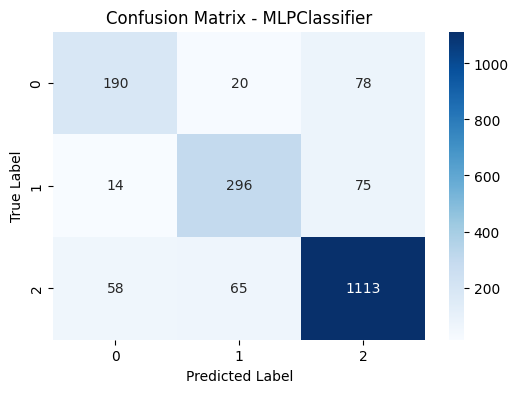

In [10]:
# List of classifiers to test
classifier_list = [
    LogisticRegression(max_iter=1000),
    SVC(),
    RandomForestClassifier(n_estimators=100),
    GradientBoostingClassifier(n_estimators=100),
    XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=300)
]

# store results
results = []
train_f1s = []
val_f1s = []
train_accs = []
val_accs = []
model_names = []

# Run evaluation for each classifier
for clf in classifier_list:
    macro_f1, acc, train_macro_f1, train_acc = train_and_evaluate_classifier(
        clf, X_train_features, y_train_labels, X_val_features, y_val_labels
    )

    results.append({
        'Classifier': clf.__class__.__name__,
        'Train Macro F1': train_macro_f1,
        'Val Macro F1': macro_f1,
        'Train Accuracy': train_acc,
        'Val Accuracy': acc
    })

    model_names.append(clf.__class__.__name__)
    train_f1s.append(train_macro_f1)
    val_f1s.append(macro_f1)
    train_accs.append(train_acc)
    val_accs.append(acc)

### Summary results table

In [11]:
# Convert results to DataFrame and sort by Val Macro F1
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='Val Macro F1', ascending=False).reset_index(drop=True)

print("\n--- Classifier Comparison Table ---")
display(results_df)



--- Classifier Comparison Table ---


,Classifier,Train Macro F1,Val Macro F1,Train Accuracy,Val Accuracy
0,MLPClassifier,0.999858,0.784481,0.999869,0.837611
1,XGBClassifier,1.000000,0.772648,1.000000,0.834992
2,LogisticRegression,0.862783,0.758407,0.896123,0.816658
3,SVC,0.786688,0.754899,0.846738,0.823468
4,GradientBoostingClassifier,0.857791,0.753691,0.895468,0.822944
5,RandomForestClassifier,1.000000,0.720739,1.000000,0.807229


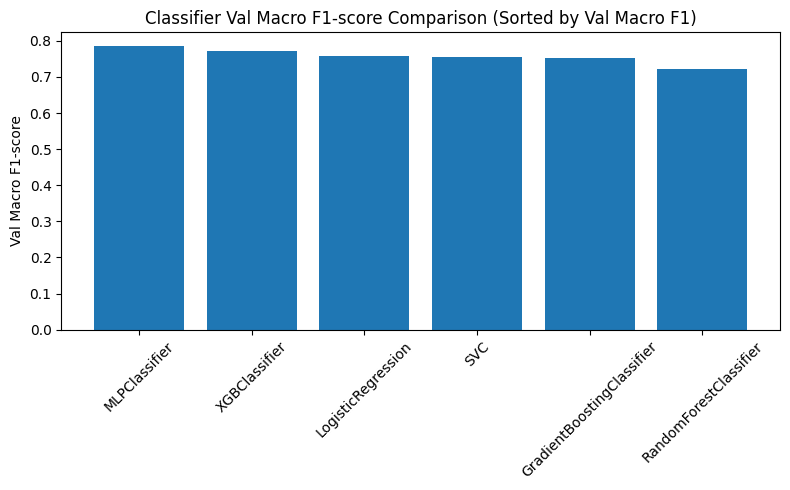

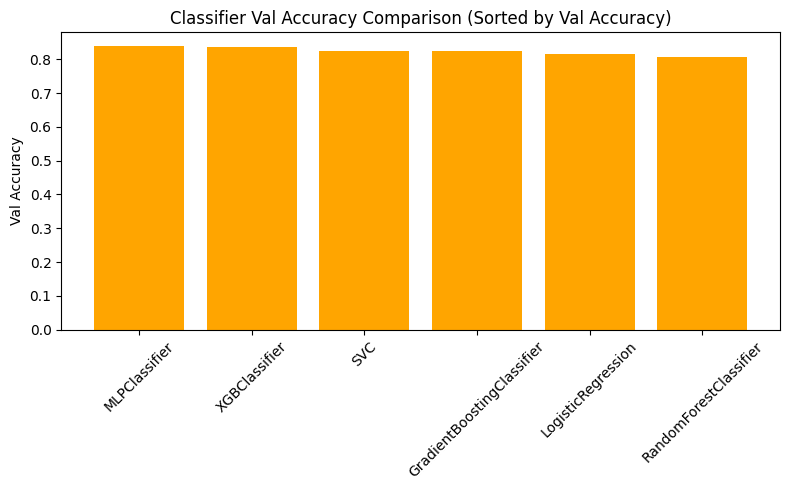

In [12]:
# Sort by Macro F1 for Macro F1 plot
sorted_by_f1 = results_df.sort_values(by='Val Macro F1', ascending=False).reset_index(drop=True)

plt.figure(figsize=(8, 5))
plt.bar(sorted_by_f1['Classifier'], sorted_by_f1['Val Macro F1'])
plt.xticks(rotation=45)
plt.ylabel("Val Macro F1-score")
plt.title("Classifier Val Macro F1-score Comparison (Sorted by Val Macro F1)")
plt.tight_layout()
plt.show()

# Sort by Accuracy for Accuracy plot
sorted_by_acc = results_df.sort_values(by='Val Accuracy', ascending=False).reset_index(drop=True)

plt.figure(figsize=(8, 5))
plt.bar(sorted_by_acc['Classifier'], sorted_by_acc['Val Accuracy'], color='orange')
plt.xticks(rotation=45)
plt.ylabel("Val Accuracy")
plt.title("Classifier Val Accuracy Comparison (Sorted by Val Accuracy)")
plt.tight_layout()
plt.show()

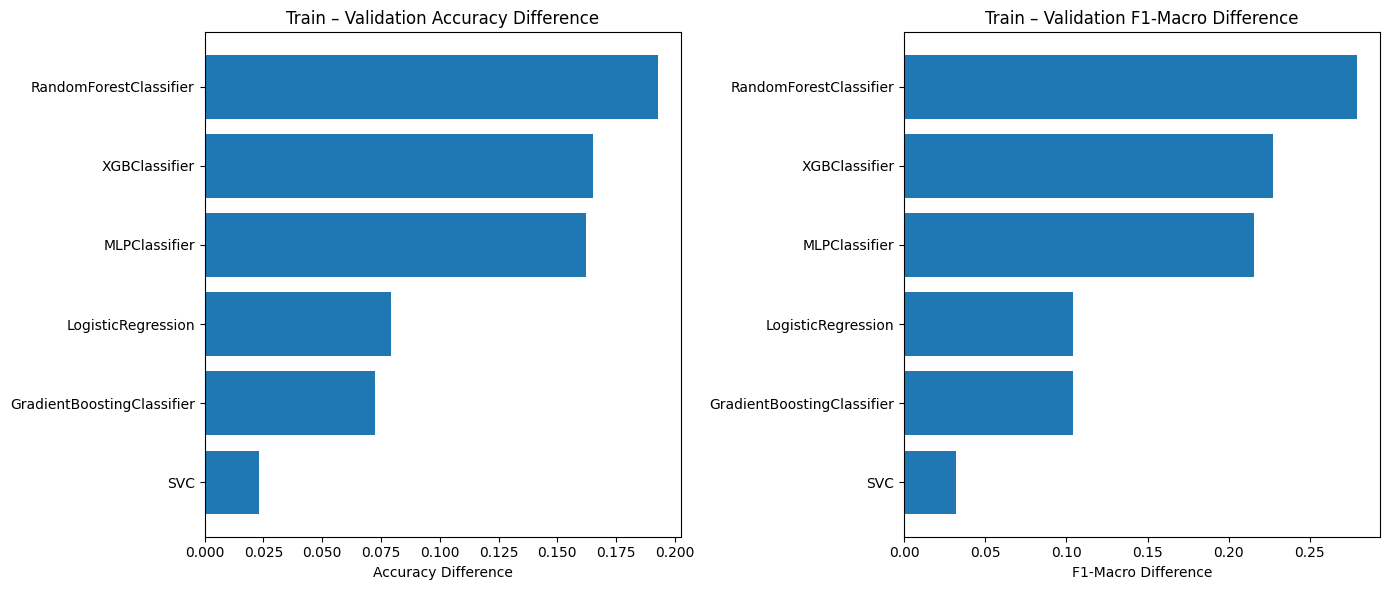

In [13]:
# Convert to numpy arrays
train_accs = np.array(train_accs)
val_accs = np.array(val_accs)
train_f1s = np.array(train_f1s)
val_f1s = np.array(val_f1s)

# Differences
diff_acc = train_accs - val_accs
diff_f1  = train_f1s  - val_f1s

# Ordering
order_acc = np.argsort(-diff_acc)
order_f1  = np.argsort(-diff_f1)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=False)

# Accuracy difference
axes[0].barh(
    np.array(model_names)[order_acc],
    diff_acc[order_acc]
)
axes[0].set_title('Train – Validation Accuracy Difference')
axes[0].set_xlabel('Accuracy Difference')
axes[0].invert_yaxis()

# F1‐macro difference
axes[1].barh(
    np.array(model_names)[order_f1],
    diff_f1[order_f1]
)
axes[1].set_title('Train – Validation F1-Macro Difference')
axes[1].set_xlabel('F1-Macro Difference')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()